# Model training with the distil labs platform

The **distil labs** platform allows anyone to benefit from state-of-the-art methods for model fine-tuning. You don’t need to be a machine learning expert to get a highly performant model customized to your needs in a matter of a day. 


# Overview
In this notebook, we will train a small language model (SLM) with the **distil labs** platform. We will follow a three-step process and, at the end, download our own SLM for local deployment.


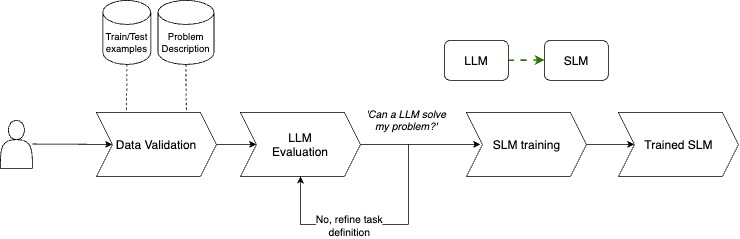

1. **Data Validation**: We start by uploading and validating our minimal dataset. To use distil labs, you need just a few examples (per class) and a problem description as discussed in [Data Preparation Guidelines for Classification](https://coconut-alto-537.notion.site/Data-Preparation-Guidelines-for-Classification-143fa0761dee80fca593e7a0bc4ee88e?pvs=4). 
2. **Teacher Evaluation**: In this step, we validate if a large language model (LLM) can accurately solve the task. If the accuracy is too low, we will iterate on the task description to improve performance.
3. **SLM Training**: Finally, we will use all available data (labelled and unlabelled) to train a specialized SLM to match the performance of the LLM on our specific task.



### Notebook settings

In [ ]:
! pip install pandas requests rich

In [ ]:
import pandas
pandas.set_option("display.max_rows", 10)

#### distil labs authentification

To begin, we need to authenticate. You should use your **distil labs** login and password to generate a temporary API key that will be used for authentification during this tutorial; it is valid for 1h so please re-authenticate if a `403 Forbidden` errors appear.

In [ ]:
import requests
import getpass
import json
import os

def distil_bearer_token(DL_USERNAME: str, DL_PASSWORD: str) -> str:
    response = requests.post(
        "https://cognito-idp.eu-central-1.amazonaws.com",
        headers={
            "X-Amz-Target": "AWSCognitoIdentityProviderService.InitiateAuth",
            "Content-Type": "application/x-amz-json-1.1",
        },
        data=json.dumps({
            "AuthParameters": {
                "USERNAME": DL_USERNAME,
                "PASSWORD": DL_PASSWORD,
            },
            "AuthFlow": "USER_PASSWORD_AUTH",
            "ClientId" : "4569nvlkn8dm0iedo54nbta6fd",
        })
    )
    response.raise_for_status()
    return response.json()["AuthenticationResult"]["AccessToken"]

DL_USERNAME = "USERNAME"
DL_PASSWORD = "PASSWORD"


AUTH_HEADER = {"Authorization": distil_bearer_token(DL_USERNAME, DL_PASSWORD)}
print("Success")

# Data Validation

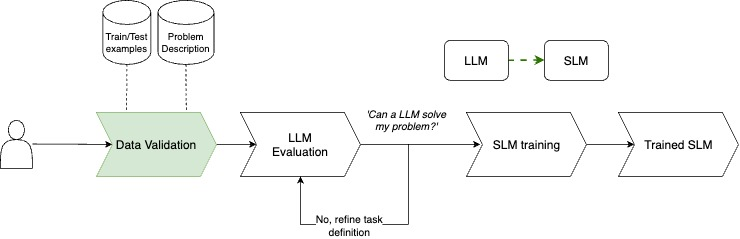

To get started with model training we need to upload the necessary data components. The details of formatting are discussed in [Data Preparation Guidelines for Classification](https://coconut-alto-537.notion.site/Data-Preparation-Guidelines-for-Classification-143fa0761dee80fca593e7a0bc4ee88e?pvs=4) but if you don't have a dataset ready, you can follow one of the data preparation notebooks to prepare an example dataset. Each distil labs training relies on:

1. **Job description** that explains the classification task and describes all classes
2. **Train and test dataset** (~10s examples) which demonstrates our expected inputs and outputs
3. (optional) **Unstructured dataset** with unlabelled data points related to the problem

In [ ]:
from pathlib import Path
data_location = Path("<ENTER DATA DIRECTORY>")
assert data_location.exists()

The data for this example should be stored in the `data_location` directory. Lets first take a look at the current directory to make sure all files are available. Your current directory should look like:

```
├── README.md
├── classification-training.ipynb
└── <data_location>
    ├── job_description.json
    ├── test.csv
    ├── train.csv
    └── unstructured.csv

```

#### Job Description
A job description explains the classification task in plain english and follows the general structure below:

```
{
  "task_description": "<Enter job description here>",
  "classes_description":
    {
      "class A": "<Enter class A description here>",
      "class B": "<Enter class B description here>",
      ...
    }
}
```

For this problem, we use the job description stored in `data_location/`, lets inspect the job_description prepared for our problem:

In [ ]:
import json
import rich.json

with open(data_location.joinpath("job_description.json")) as fin:
    rich.print(rich.json.JSON(fin.read()))

#### Train and test data
We need a small train data to begin disti labs training and a testing dataset that we can use to evaluate the performance of the fine-tuned model. Here, we use the train and test datasets from the `data_location` directory where each is a **JSON**-lines file with below 100 (`question`, `answer`) pairs.

Let's inspect the available datasets to see the format and a few examples.

In [ ]:
from pathlib import Path
from IPython.display import display

import pandas

print("# --- Train set")
train = pandas.read_csv(data_location.joinpath("train.csv"))
display(train)

print("# --- Test set")
test = pandas.read_csv(data_location.joinpath("test.csv"))
display(test)

#### Unstructured dataset
The unstructured dataset is used to guide the teacher model in generating diverse, domain-specific data. It can be documentation, unlabelled examples, or even industry literature that contains such information. Here, we use the unstructured datasets from the `data_location/` directory where each is a **JSON**-lines with a single column (`context`).

Let's inspect the available datasets to see the format and a few examples.

In [ ]:
unstructured = pandas.read_csv(data_location.joinpath("unstructured.csv"))
display(unstructured)

### Upload and Validate data 

We upload all data elements to the distil labs plaform use the data validation API to check if everything is in order for our jobs. 

In [ ]:
from pathlib import Path
from pprint import pprint
import json
import requests


data = {
    "job_description.json": open(data_location.joinpath("job_description.json")).read(),
    "test.csv": open(data_location.joinpath("test.csv")).read(),
    "train.csv": open(data_location.joinpath("train.csv")).read(),
    "unstructured.csv": open(data_location.joinpath("unstructured.csv")).read(),
}


response = requests.post(
    f"https://api.distillabs.ai/uploads",
    data=json.dumps(data),
    headers={
        "content-type": "application/json",
        **AUTH_HEADER,
    },
)

upload_id = response.json().get("id")
pprint(response.json())

# Teacher evaluation

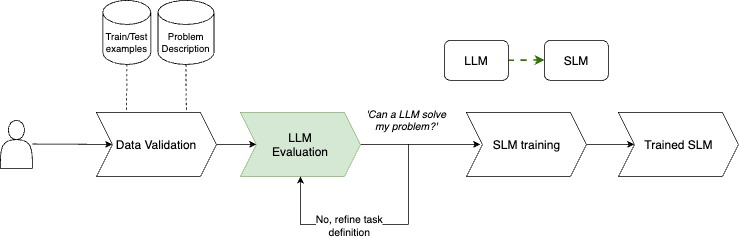


In the teacher evaluation stage, we will use our test set to validate whether our chosen 'teacher' LLM can solve the task well enough. 

If a large model can solve a problem, we can then distil the problem-solving ability of the larger model into a small model. The accuracy of the teacher LLM will give us an idea of the performance to expect from our SLM.

In [ ]:
import time
from pprint import pprint

response = requests.post(
    f"https://api.distillabs.ai/teacher-evaluations/{upload_id}",
    headers=AUTH_HEADER,
)

pprint(response.json())
teacher_evaluation_id = response.json().get("id")

#### Check status and results
Run the cell below to check the status and results of the LLM evaluation.

High accuracy on LLM evaluation indicates our task is well defined and we can move on to training. When training an SLM for this task, we can use the LLM evaluation as the quality benchmark for the trained model.

In [ ]:
import json
from pprint import pprint

response = requests.get(
    f"https://api.distillabs.ai/teacher-evaluations/{teacher_evaluation_id}/status",
    headers=AUTH_HEADER,
)
pprint(response.json())


# SLM Training

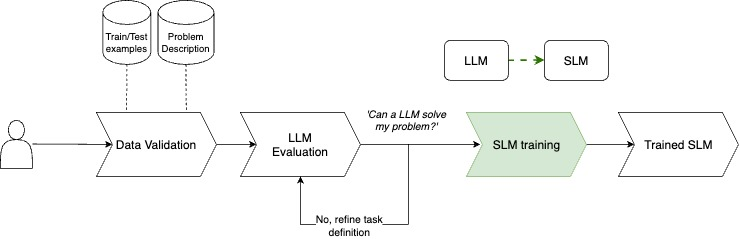

Now that we are satisfied with the LLM evaluation, we will start the **distil labs** training process where the SLM learns to mimic the LLM's behavior on your specific task. Once the training is complete, we will review the SLM's performance against the LLM's benchmark and decide if the quality meets your requirements. 

To kick off the training job, we can use the following code snippet below that starts the training loop and returns the job tag of the initialized training job. In the subsequent steps, the job tag will be used to manage the training process's lifecycle. 

In [ ]:
import time
from pprint import pprint

# Start SLM training
response = requests.post(
    f"https://api.distillabs.ai/trainings/{upload_id}",
    headers=AUTH_HEADER,
)

pprint(response.json())
slm_training_job_id = response.json().get("id")
time.sleep(60)

#### Training status and evaluation results
We can analyze the status of the training job using the `jobs` API. The following code snippets displays the current status of the job we started before. **Note that it takes a couple minutes for the new job to register before we can check its status**.

In [ ]:
import json

response = requests.get(
    f"https://api.distillabs.ai/trainings/{slm_training_job_id}/status",
    headers=AUTH_HEADER,
)
response.json()


When the job is finished (`status=complete`), we can use the `jobs` API again to get the benchmarking result - the accuracy of the LLM and the accuracy of the fine-tuned SLM. We can achieve this using:

In [ ]:
from pprint import pprint
response = requests.get(
    f"https://api.distillabs.ai/trainings/{slm_training_job_id}/evaluation-results",
    headers=AUTH_HEADER,
)

pprint(response.json())


#### Interpreting results
Inspecting the classification results, we can compare the accuracy of the small model (1B parameters) to the teacher model with 70x the size. In most cases, the accuracy should be comparable, indicating successful training.

# SLM Ready


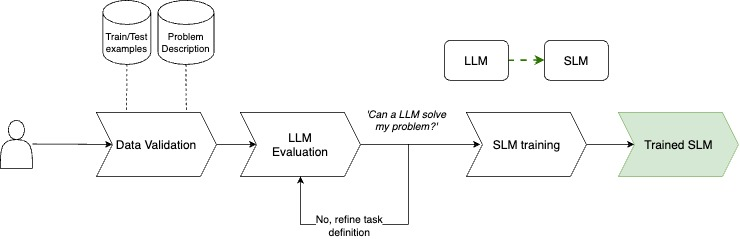

Once the model is fully trained, we can share the model binaries with you, so you can deploy it on your own infrastructure and have full control. The model binaries can be downloaded using the `model` API by downloading the tarball and extracting into to the `model` directory. A trained model can be later deployed for inference; this is explained in the next tutorial: classification_model_deployment.ipynb

In [ ]:
from pprint import pprint

response = requests.get(
    f"https://api.distillabs.ai/trainings/{slm_training_job_id}/model",
    headers=AUTH_HEADER,
)
pprint(response.json())